In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools

import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import cv2

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from quinn_embedding_stimuli import *
from quinn_embedding_models import *

In [4]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## Plotting and analysis functions


## Object generator and sample

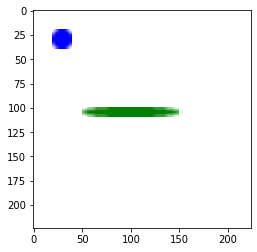

In [5]:
target_size = 20
reference_size = (10, 100)
reference_positions = [(105, 100)]

target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='green')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, target_patch, reference_patch,
                             blur_func=blur_func)
x = gen.generate((30, 30), reference_positions)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

In [6]:
every = 5
half_target = target_size // 2
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
target_positions = [(r * every, c * every) for r, c 
                    in itertools.product(range(half_target // every, row_max // every), 
                                         range(half_target // every, col_max // every))]

batch = gen.batch_generate(target_positions, reference_positions)
batch.shape

torch.Size([1600, 3, 224, 224])

In [7]:
miniature_stimuli_every = 20
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
miniature_target_positions = [(r * miniature_stimuli_every, c * miniature_stimuli_every) for r, c 
                                in itertools.product(range(1, 
                                                           row_max // miniature_stimuli_every + 1), 
                                                     range(1, 
                                                           col_max // miniature_stimuli_every + 1))]
# miniature_target_positions
miniature_batch = gen.batch_generate(miniature_target_positions, reference_positions)
miniature_batch.shape

torch.Size([100, 3, 224, 224])

In [18]:
class AboveBelowEquilateralTripletGenerator:
    def __init__(self, stimulus_generator, side_length_endpoints, 
                 vertical_margin=0, horizontal_margin=0,
                 target_margin_from_reference_edge=0, pair_above=None,
                 seed=RANDOM_SEED):
        self.stimulus_generator = stimulus_generator
        
        if not hasattr(side_length_endpoints, '__len__'):
            side_length_endpoints = (side_length_endpoints, side_length_endpoints)
            
        self.side_length_endpoints = side_length_endpoints
            
        self.vertical_margin = vertical_margin
        self.horizontal_margin = horizontal_margin
        
        self.target_margin_from_reference_edge = target_margin_from_reference_edge
        self.pair_above = pair_above
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
    
    def __call__(self, n=1, normalize=True):
        results = []
        for _ in range(n):
            side_length = self.rng.integers(*self.side_length_endpoints)
            height = (3 ** 0.5) * side_length / 2
            half_height = height // 2
            min_vertical_margin = height + (self.stimulus_generator.target_size[1] // 2)
            
            vertical_margin = max(min_vertical_margin, self.vertical_margin)
            horizontal_margin = max(self.stimulus_generator.reference_size[1] // 2, self.horizontal_margin)
            
            reference_center_position = np.array(
                (self.rng.integers(vertical_margin, self.stimulus_generator.canvas_size[0] - vertical_margin),
                 self.rng.integers(horizontal_margin, self.stimulus_generator.canvas_size[1] - horizontal_margin)), 
                dtype=np.int)
            
            target_margin = (self.stimulus_generator.reference_size[1] - self.stimulus_generator.target_size[1]) // 2
            left_target_horizontal_offset = self.rng.integers(-target_margin, target_margin - side_length)
            middle_target_horizontal_offset = left_target_horizontal_offset + side_length // 2
            right_target_horizontal_offset = left_target_horizontal_offset + side_length
            
            if self.pair_above is None:
                pair_above = np.sign(self.rng.uniform(-0.5, 0.5))
            else:
                pair_above = self.pair_above and 1 or -1
                
            left_target_offset = np.array((pair_above * half_height, left_target_horizontal_offset), dtype=np.int)
            middle_target_offset = np.array((-1 * pair_above * half_height, middle_target_horizontal_offset), dtype=np.int)
            right_target_offset = np.array((pair_above * half_height, right_target_horizontal_offset), dtype=np.int)
            
            target_positions = [reference_center_position + offset for offset in 
                                (left_target_offset, right_target_offset, middle_target_offset)]
            
            results.append(self.stimulus_generator.batch_generate(target_positions, [reference_center_position], normalize=normalize))
        
        return torch.stack(results)
    
    
class AboveBelowQuinnTripletGenerator:
    def __init__(self, stimulus_generator, distance_endpoints, 
                 vertical_margin=0, horizontal_margin=0,
                 target_margin_from_reference_edge=0, 
                 pair_above=None, two_objects_left=None,
                 seed=RANDOM_SEED):
        self.stimulus_generator = stimulus_generator
        
        if not hasattr(distance_endpoints, '__len__'):
            distance_endpoints = (distance_endpoints, distance_endpoints)
            
        self.distance_endpoints = distance_endpoints
            
        self.vertical_margin = vertical_margin
        self.horizontal_margin = horizontal_margin
        
        self.target_margin_from_reference_edge = target_margin_from_reference_edge
        self.pair_above = pair_above
        self.two_objects_left = two_objects_left
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
    
    def __call__(self, n=1, normalize=True):
        results = []
        for _ in range(n):
            distance = self.rng.integers(*self.distance_endpoints)
            half_distance = distance // 2
            min_vertical_margin = distance + (self.stimulus_generator.target_size[1] // 2)
            
            vertical_margin = max(min_vertical_margin, self.vertical_margin)
            horizontal_margin = max(self.stimulus_generator.reference_size[1] // 2, self.horizontal_margin)
            
            reference_center_position = np.array(
                (self.rng.integers(vertical_margin, self.stimulus_generator.canvas_size[0] - vertical_margin),
                 self.rng.integers(horizontal_margin, self.stimulus_generator.canvas_size[1] - horizontal_margin)), 
                dtype=np.int)
            
            target_margin = (self.stimulus_generator.reference_size[1] - self.stimulus_generator.target_size[1]) // 2
            left_target_horizontal_offset = self.rng.integers(-target_margin, target_margin - distance)
            right_target_horizontal_offset = left_target_horizontal_offset + distance
            
            if self.pair_above is None:
                pair_above = np.sign(self.rng.uniform(-0.5, 0.5))
            else:
                pair_above = self.pair_above and 1 or -1
            
            two_objects_left = self.two_objects_left
            if two_objects_left is None:
                two_objects_left = self.rng.integers(0, 2)
                
            left_target_offset = np.array((pair_above * half_distance, left_target_horizontal_offset), dtype=np.int)
            right_target_offset = np.array((pair_above * half_distance, right_target_horizontal_offset), dtype=np.int)
            other_side_target_offset = np.array((-pair_above * half_distance, two_objects_left and left_target_horizontal_offset or right_target_horizontal_offset), dtype=np.int)
            
            target_positions = [reference_center_position + offset for offset in 
                                (left_target_offset, right_target_offset, other_side_target_offset)]
            
            results.append(self.stimulus_generator.batch_generate(target_positions, [reference_center_position], normalize=normalize))
        
        return torch.stack(results)


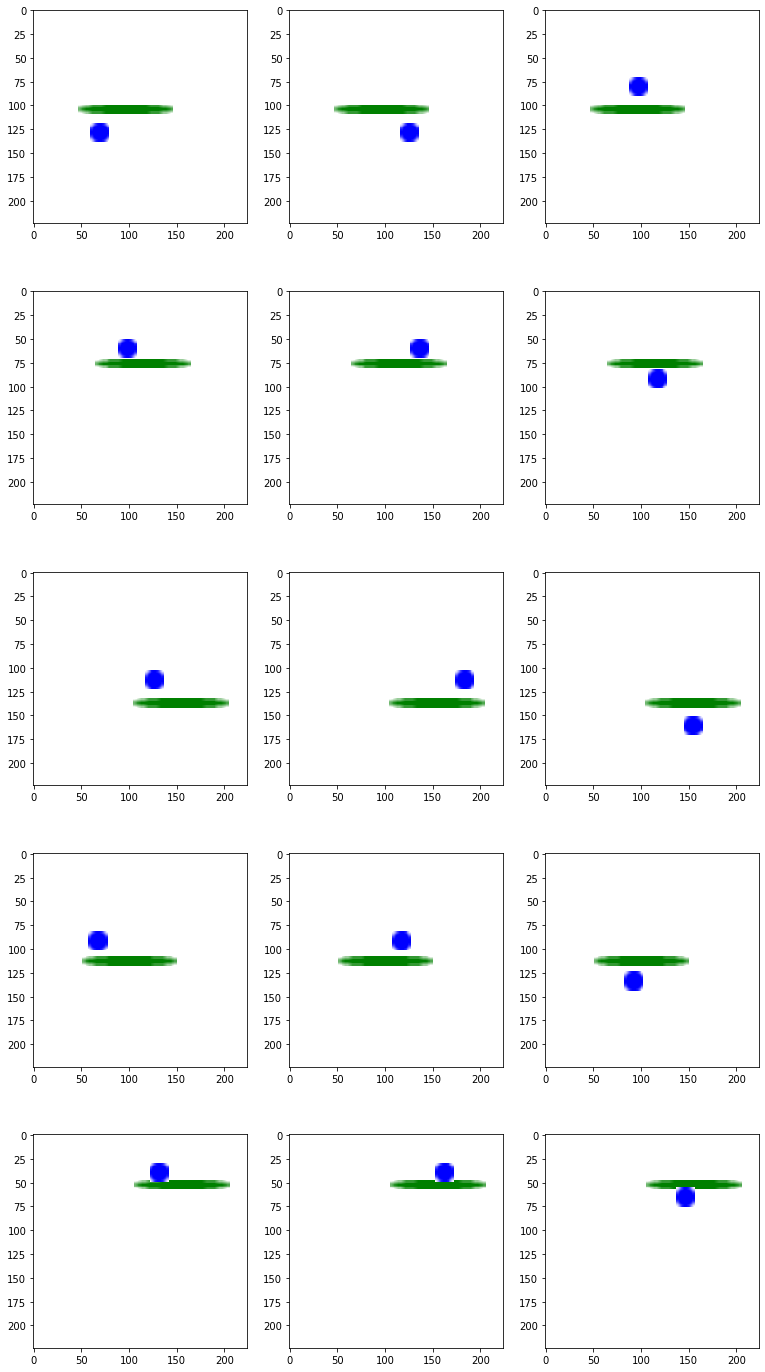

In [19]:
N = 5

ab = AboveBelowEquilateralTripletGenerator(gen, (30, 60))
results = ab(N, normalize=False)

plt.figure(figsize=(13, 5 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


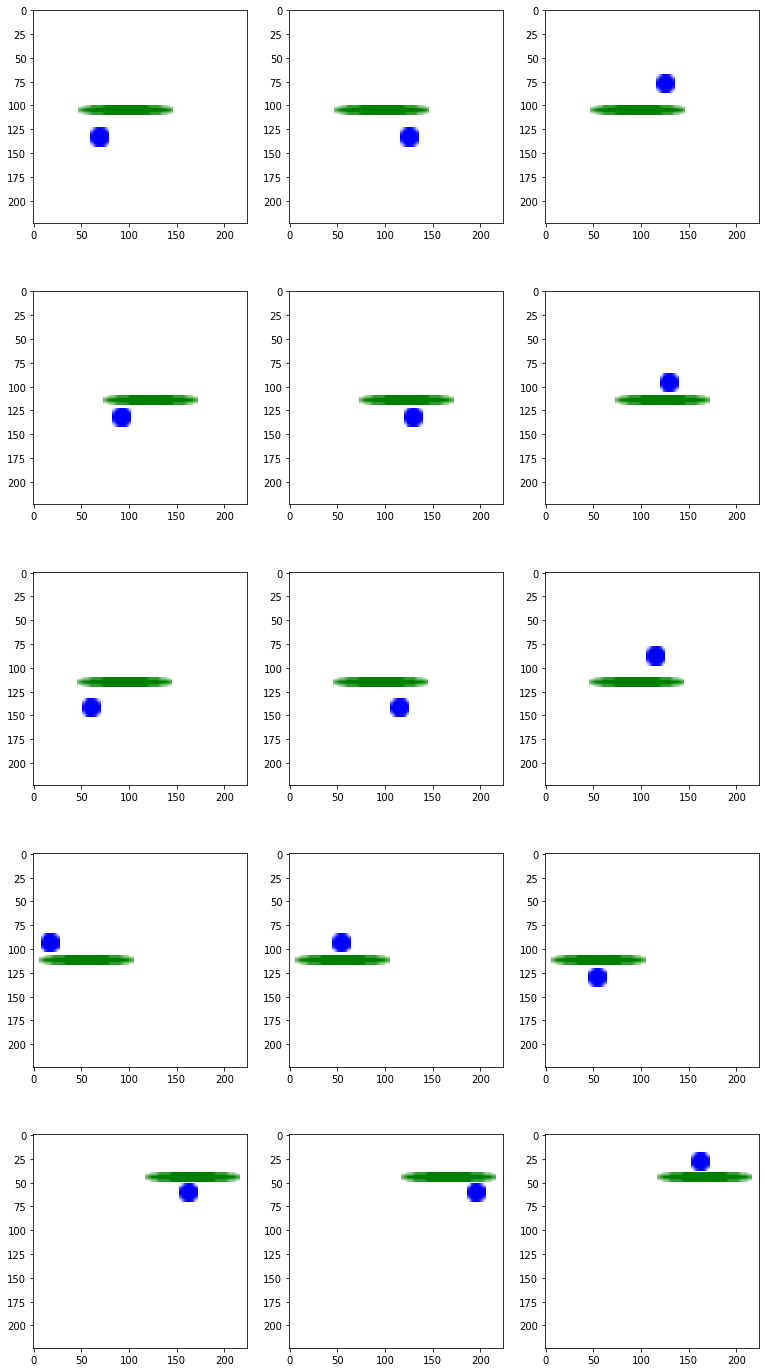

In [20]:
N = 5

ab = AboveBelowQuinnTripletGenerator(gen, (30, 60))
results = ab(N, normalize=False)

plt.figure(figsize=(13, 5 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()
